## Modelling for Mid

### Preprocessing

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

final_df = pd.read_csv("plch_uncorr_elo_v2.csv")

# 1. Filter for "Att Mid / Wingers"
df_mid = final_df[final_df["Position"] == "Midfielders"].copy()

df_mid

,Player,Birthdate,League,Club,Footed,Nationality,Position,Minutes,Goals,Assists,...,Carries into Penalty Area,Miscontrols,Dispossessed,Fouls Committed,Fouls Drawn,Offsides,Ball Recoveries,Aerials Won,overall,Elo
2,Ryan Gravenberch,2002-05-16,PremierLeague,Liverpool,Right,Netherlands,Midfielders,3160,0.00,0.11,...,0.28,1.57,0.74,1.34,1.48,0.00,5.50,0.74,84,1993
3,Alexis Mac Allister,1998-12-24,PremierLeague,Liverpool,Right,Argentina,Midfielders,2599,0.17,0.17,...,0.17,1.07,0.76,2.15,1.39,0.07,5.13,0.66,86,1993
10,Curtis Jones,2001-01-30,PremierLeague,Liverpool,Right,England,Midfielders,1712,0.16,0.16,...,0.42,1.37,1.89,0.95,1.31,0.05,5.10,0.74,80,1993
16,Declan Rice,1999-01-14,PremierLeague,Arsenal,Right,England,Midfielders,2825,0.13,0.22,...,0.51,1.15,1.02,0.67,0.51,0.06,4.97,1.18,87,1993
17,Thomas Partey,1993-06-13,PremierLeague,Arsenal,Right,Ghana,Midfielders,2797,0.13,0.06,...,0.10,0.77,0.55,1.45,1.00,0.03,4.44,0.90,83,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,Emmanouil Siopis,1994-05-14,EFLChampionship,Panathinaikos,Right,Greece,Midfielders,1444,0.00,0.00,...,0.06,1.06,1.25,0.69,1.75,0.00,5.05,0.69,75,1410
615,Joe Ralls,1993-10-12,EFLChampionship,Cardiff City,Left,England,Midfielders,1148,0.00,0.08,...,0.31,1.02,0.63,2.12,0.78,0.00,4.55,0.94,70,1434
619,Sivert Mannsverk,2002-05-08,EFLChampionship,Cardiff City,Right,Norway,Midfielders,1004,0.00,0.09,...,0.18,1.17,1.08,1.61,0.54,0.00,5.20,2.78,68,1434
621,David Turnbull,1999-07-10,EFLChampionship,Cardiff City,Right,Scotland,Midfielders,826,0.11,0.00,...,0.00,0.76,0.76,1.09,0.11,0.00,4.90,0.65,71,1434


In [2]:
# 2. Define target and input features //
target = "overall"
drop_cols = ["Player", "Birthdate", "League", "Club", "Nationality", "Footed", "Position", "Minutes", "Club_x", "Aerials Lost", "Errors"]

midfielders_features = [
    'Assists', 'npxG + xAG',                          # Playmaking and shot creation
    'Progressive Carries', 'Progressive Carrying Distance', # Ball progression through midfield
    'Touches (Att 3rd)', 'Touches (Def 3rd)',         # Influence in both halves
    'Pass Completion %', 'Live-ball Passes',          # Ball security
    'Progressive Passes', 'Progressive Passing Distance', # Advancing team forward
    'Passes Attempted (Long)', 'Pass Completion % (Long)',# Range of passing
    'Passes into Final Third', 'Switches',            # Penetrative and expansive passing
    'Through Balls',                                  # Breaking lines
    'SCA (Live-ball Pass)', 'SCA (Take-On)',          # Shot creation
    'SCA (Defensive Action)',                         # Disrupting opponents before shots
    'GCA (Live-ball Pass)', 'GCA (Defensive Action)', # Goal creation and last-ditch defending
    'Tackles (Mid 3rd)',                              # Defensive work rate in midfield
    'Tkl+Int',                                        # Ball-winning combined metric
    'Blocks',                                         # Blocking passes/shots
    'Ball Recoveries',                                # Regaining possession
    'Fouls Committed', 'Fouls Drawn',                 # Physical/technical battle
    'Aerials Won',                                    # Midfield duels                                      # Costly mistakes
    'Elo'                                             # Context
]

In [3]:
X = df_mid.drop(columns=drop_cols + [target], errors="ignore")
X = X[midfielders_features]
y = df_mid[target]
numeric_features = X.select_dtypes(include="number").columns.tolist()


# 3. Preprocessing pipeline // min-maxscaling for numeric features
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
])

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
# 5. Initiate method that will train and evaluate different models 

def evaluate_model(
    name,
    model,
    preprocessor_override=None,
    X_train_override=None,
    X_test_override=None,
    y_train_override=None,
    y_test_override=None
):
    # Use overrides or fall back to global variables
    X_train_local = X_train_override if X_train_override is not None else X_train
    X_test_local = X_test_override if X_test_override is not None else X_test
    y_train_local = y_train_override if y_train_override is not None else y_train
    y_test_local = y_test_override if y_test_override is not None else y_test
    preprocessor_local = preprocessor_override if preprocessor_override is not None else preprocessor

    # Define pipeline
    pipe = Pipeline([
        ("preprocess", preprocessor_local),
        ("regressor", model)
    ])

    # Fit and predict
    pipe.fit(X_train_local, y_train_local)
    y_pred = pipe.predict(X_test_local)

    # Cross-validation (on full data)
    cv_score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    mean_cv_mae = -np.mean(cv_score)

    return {
        "Model": name,
        "MAE": mean_absolute_error(y_test_local, y_pred),
        "RMSE": root_mean_squared_error(y_test_local, y_pred),
        "5-CV": mean_cv_mae,
        "R2": r2_score(y_test_local, y_pred),
        "Pipeline": pipe
    }

### Linear Models

In [5]:
results = []

# Lasso
results.append(evaluate_model("Lasso", LassoCV(cv=5)))

# Get the trained Lasso pipeline
lasso_pipe = results[0]["Pipeline"]  # Assuming Lasso is first in results

# Access the Lasso model and preprocessor
lasso_model = lasso_pipe.named_steps["regressor"]
scaler = lasso_pipe.named_steps["preprocess"]

# Get feature names from preprocessor
feature_names = scaler.transformers_[0][2]  # ['num', scaler, [feature list]]

# Get non-zero coefficients
import pandas as pd
coefs = pd.Series(lasso_model.coef_, index=feature_names)
non_zero_coefs = coefs[coefs != 0].sort_values(key=abs, ascending=False)

print("Non-zero Lasso Coefficients:")
print(non_zero_coefs)

Non-zero Lasso Coefficients:
Elo                              3.301529
Assists                          1.087532
Pass Completion %                0.437210
Tkl+Int                          0.410715
Progressive Carrying Distance    0.231361
SCA (Defensive Action)           0.185049
npxG + xAG                       0.119685
GCA (Live-ball Pass)             0.076594
Pass Completion % (Long)         0.050750
SCA (Live-ball Pass)             0.045703
dtype: float64


In [6]:
# Lasso + XGBoost
lasso = Pipeline([
    ("preprocessor", preprocessor),
    ('lasso', LassoCV(cv=5))
])
lasso.fit(X_train, y_train)
selected_features = np.array(numeric_features)[lasso.named_steps["lasso"].coef_ != 0]

selected_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), selected_features.tolist())
])

results.append(evaluate_model(
    name="Lasso+XGBoost",
    model=XGBRegressor(n_estimators=100),
    preprocessor_override=selected_preprocessor,
    X_train_override=X_train[selected_features],
    X_test_override=X_test[selected_features],
    y_train_override=y_train,
    y_test_override=y_test
))

### Elastic Net with correlated features to target variable

In [33]:
# Select top k features with strongest correlation to target
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
selector = SelectKBest(score_func=f_regression, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = selector.get_feature_names_out(input_features=X.columns)

# Train/test split
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X[selected_features], y, test_size=0.15
)

# Preprocessing and model
preprocessor_sel = ColumnTransformer([
    ("num", StandardScaler(), selected_features)
])
model = ElasticNetCV(cv=5, max_iter=5000)

pipeline = Pipeline([
    ("preprocess", preprocessor_sel),
    ("regressor", model)
])

# Fit and predict
pipeline.fit(X_train_sel, y_train_sel)
y_pred_sel = pipeline.predict(X_test_sel)

# Evaluate and store
results.append({
    "Model": "ElasticNet (Top15 SelectKBest)",
    "MAE": mean_absolute_error(y_test_sel, y_pred_sel),
    "RMSE": root_mean_squared_error(y_test_sel, y_pred_sel),
    "5-CV": -cross_val_score(pipeline, X[selected_features], y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test_sel, y_pred_sel),
    "Pipeline": pipeline
})

### Stacked Model

In [8]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline

# Define base and meta learners
base_model = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, random_state=42))
meta_model = XGBRegressor(n_estimators=100)

# Wrap ElasticNet and XGBoost in stacking regressor
stacked_model = StackingRegressor(
    estimators=[("elasticnet", base_model)],
    final_estimator=meta_model,
    passthrough=True  # includes original features as well
)

# Train/test split stays the same
stacked_model.fit(X_train, y_train)
y_pred_stack = stacked_model.predict(X_test)

# Evaluate
results.append({
    "Model": "ElasticNet→XGBoost (Stacked)",
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "RMSE": root_mean_squared_error(y_test, y_pred_stack),
    "5-CV": cross_val_score(stacked_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_stack),
    "Pipeline": stacked_model
})

### Hyperparamater tuning for RF & XG

In [9]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def rf_objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }

    model = RandomForestRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()  # Optuna minimizes

# Run the study
rf_study = optuna.create_study(direction="minimize")
rf_study.optimize(rf_objective, n_trials=100)

# Best model
best_rf = RandomForestRegressor(**rf_study.best_params)

[I 2025-06-12 16:03:06,198] A new study created in memory with name: no-name-7d348fd8-13bd-415c-a892-d370cd225c41
[I 2025-06-12 16:03:09,914] Trial 0 finished with value: 3.7974390535940272 and parameters: {'n_estimators': 974, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 3.7974390535940272.
[I 2025-06-12 16:03:10,422] Trial 1 finished with value: 3.2842149064437534 and parameters: {'n_estimators': 344, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 3.2842149064437534.
[I 2025-06-12 16:03:10,697] Trial 2 finished with value: 4.256522215959563 and parameters: {'n_estimators': 241, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 3.2842149064437534.
[I 2025-06-12 16:03:11,066] Trial 3 finished with value: 3.4100758287441977 and parameters: {'n_estimators': 196, 'max_depth': 29, 'min_

In [10]:
# Create pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_rf)
])

# Fit and predict
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

results.append({
    "Model": "RandomForest (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": root_mean_squared_error(y_test, y_pred_rf),
    "5-CV": - cross_val_score(rf_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_rf),
    "Pipeline": rf_pipeline
})

In [11]:
from xgboost import XGBRegressor

def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    model = XGBRegressor(**params, n_jobs=-1)
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    score = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_absolute_error")
    return -score.mean()

# Run the study
xgb_study = optuna.create_study(direction="minimize")
xgb_study.optimize(xgb_objective, n_trials=100)

# Best model
best_xgb = XGBRegressor(**xgb_study.best_params)

[I 2025-06-12 16:04:39,923] A new study created in memory with name: no-name-deefdda3-5743-46c0-8c46-60a99a8989c3
[I 2025-06-12 16:04:40,530] Trial 0 finished with value: 3.887038828531901 and parameters: {'n_estimators': 394, 'max_depth': 11, 'learning_rate': 0.09091624600798535, 'subsample': 0.9302806475624747, 'colsample_bytree': 0.7304606181438638, 'gamma': 0.5926868741009989, 'reg_alpha': 0.2866043487554689, 'reg_lambda': 0.640773487238278}. Best is trial 0 with value: 3.887038828531901.
[I 2025-06-12 16:04:40,866] Trial 1 finished with value: 3.576866251627604 and parameters: {'n_estimators': 211, 'max_depth': 5, 'learning_rate': 0.16194691216278254, 'subsample': 0.6972547777284432, 'colsample_bytree': 0.7964495678856156, 'gamma': 0.12272285408639116, 'reg_alpha': 0.9816022530389977, 'reg_lambda': 0.8637745352185255}. Best is trial 1 with value: 3.576866251627604.
[I 2025-06-12 16:04:41,879] Trial 2 finished with value: 3.595006357828776 and parameters: {'n_estimators': 394, 'max

In [12]:
# Create pipeline
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_xgb)
])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)

results.append({
    "Model": "XGBoost (Optuna)",
    "MAE": mean_absolute_error(y_test, y_pred_xgb),
    "RMSE": root_mean_squared_error(y_test, y_pred_xgb),
    "5-CV": -cross_val_score(xgb_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error").mean(),
    "R2": r2_score(y_test, y_pred_xgb),
    "Pipeline": rf_pipeline
})

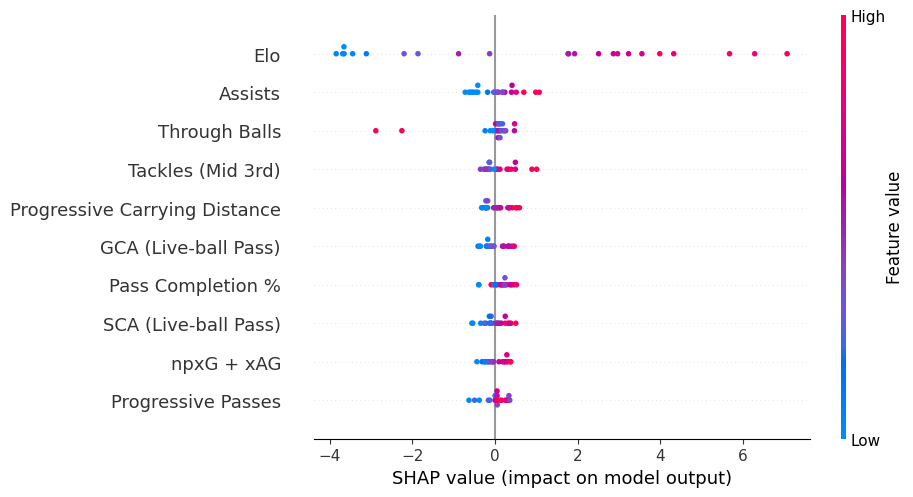

In [13]:
import shap
import numpy as np
import pandas as pd

# Extract model and transformed data
xgb_model = xgb_pipeline.named_steps["regressor"]
X_transformed = xgb_pipeline.named_steps["preprocessor"].transform(X_test)

# Extract feature names used in preprocessing
feature_names = xgb_pipeline.named_steps["preprocessor"].transformers_[0][2]

# Convert transformed data to DataFrame with proper column names
X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_transformed_df)

# Compute mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Get indices of top 10 features
top_10_indices = np.argsort(mean_abs_shap)[-10:]

# Filter SHAP values to top 10 features
shap_values_top = shap_values[:, top_10_indices]

# Plot SHAP summary (beeswarm) for top 10 features
shap.plots.beeswarm(shap_values_top)


### Modelling Results 

In [34]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by MAE (ascending)
results_df_sorted = results_df.sort_values(by="MAE", ascending=True)

# Display selected columns (optional)
display_cols = ["Model", "MAE", "RMSE", "5-CV", "R2"]
print(results_df_sorted[display_cols])

                             Model       MAE      RMSE      5-CV        R2
6   ElasticNet (Top15 SelectKBest)  1.835697  2.449322  2.998643  0.749916
11  ElasticNet (Top15 SelectKBest)  2.138972  2.955247  2.998643  0.739747
18  ElasticNet (Top15 SelectKBest)  2.162270  2.903554  2.998643  0.584284
10  ElasticNet (Top15 SelectKBest)  2.199880  2.557576  2.998643  0.768356
14  ElasticNet (Top15 SelectKBest)  2.218579  3.186002  2.998643  0.431420
13  ElasticNet (Top15 SelectKBest)  2.248869  2.882990  2.998643  0.711113
24  ElasticNet (Top15 SelectKBest)  2.271347  3.002074  2.998643  0.732158
22  ElasticNet (Top15 SelectKBest)  2.309080  2.768227  2.998643  0.726688
7   ElasticNet (Top15 SelectKBest)  2.422373  3.395738  2.998643  0.648176
17  ElasticNet (Top15 SelectKBest)  2.540183  3.229996  2.998643  0.709251
16  ElasticNet (Top15 SelectKBest)  2.617697  3.073092  2.998643  0.371279
23  ElasticNet (Top15 SelectKBest)  2.668284  3.485592  2.998643  0.606381
9   ElasticNet (Top15 Sel

### Model Saving & Shap Plots

In [35]:
import joblib

# Get the best model (lowest MAE)
best_model = results_df_sorted.iloc[0]["Pipeline"]

# Save to disk
joblib.dump(best_model, "best_model_mid.joblib")

['best_model_mid.joblib']

In [36]:
elastic = best_model.named_steps['elasticnetcv'] if 'elasticnetcv' in best_model.named_steps else best_model[-1]

# Get the StandardScaler (inside the ColumnTransformer)
preprocessor = best_model.named_steps['preprocess']

# 1. Get the list of actually used features:
feature_names = preprocessor.transformers_[0][2]  # This gets the feature names for 'num'

# 2. Coefficients from the model
coefs = elastic.coef_

# 3. Make sure lengths match
print(f"Feature names: {len(feature_names)}, Coefs: {len(coefs)}")

# 4. Now make the DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=abs, ascending=False)

print(importance_df)


Feature names: 20, Coefs: 20
                          feature  coefficient
19                            Elo     2.708884
0                         Assists     1.102435
5               Pass Completion %     0.545061
17                        Tkl+Int     0.518287
15           GCA (Live-ball Pass)     0.435245
1                      npxG + xAG     0.277096
3   Progressive Carrying Distance     0.229984
7              Progressive Passes     0.034397
11        Passes into Final Third     0.004489
13                  Through Balls    -0.000000
18                Ball Recoveries    -0.000000
16              Tackles (Mid 3rd)     0.000000
14           SCA (Live-ball Pass)     0.000000
2             Progressive Carries     0.000000
12                       Switches    -0.000000
9         Passes Attempted (Long)    -0.000000
8    Progressive Passing Distance     0.000000
6                Live-ball Passes     0.000000
4               Touches (Att 3rd)     0.000000
10       Pass Completion % (Lon

In [37]:
# Transform X_train with your pipeline up to the estimator
X_proc = best_model.named_steps['preprocess'].transform(X_train[feature_names])

/Users/ghalichraibi/anaconda3/lib/python3.11/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


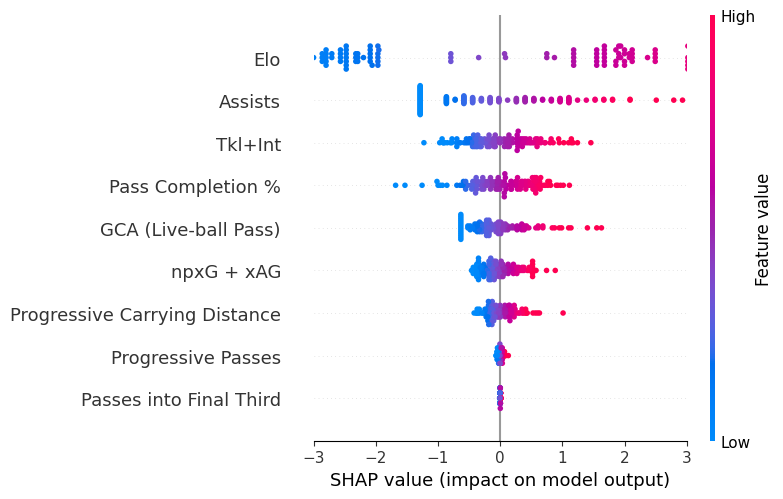

In [38]:
import shap
import matplotlib.pyplot as plt

explainer = shap.LinearExplainer(elastic, X_proc, feature_perturbation="interventional")
shap_values = explainer(X_proc)

plt.figure(figsize=(6, 8))  # Adjust for better horizontal space if needed
shap.summary_plot(
    shap_values, 
    features=X_proc, 
    feature_names=feature_names, 
    show=False, 
    max_display=9  # <-- Only show top 6 features
)
plt.xlim(-3, 3)
plt.show()
